In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ViT_ImageNet/Train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ViT_ImageNet/Val', transform=transform)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
num_classes = 160
print(f"Number of classes: {len(train_dataset.classes)}")

Number of classes: 160


In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)

#if gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
  train_acc_history = []
  val_acc_history = []

  for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = outputs.max(1)
      correct += predicted.eq(labels).sum().item()
      total += labels.size(0)

    train_acc = correct / total
    train_acc_history.append(train_acc)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Acc: {train_acc:.4f}")


    #validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()

        total += labels.size(0)


    #val acc
    val_acc = correct / total
    val_acc_history.append(val_acc)
    print(f"Validation ACC: {val_acc:.4f}")

    print()

  return train_acc_history, val_acc_history

In [ ]:
#training for 12 epochs
train_acc_history, val_acc_history =  train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10 - Loss: 1.7674 - Acc: 0.6142
Validation ACC: 0.6976

Epoch 2/10 - Loss: 0.4430 - Acc: 0.8725
Validation ACC: 0.6831

Epoch 3/10 - Loss: 0.2247 - Acc: 0.9309
Validation ACC: 0.6794

Epoch 4/10 - Loss: 0.1401 - Acc: 0.9614
Validation ACC: 0.6885

Epoch 5/10 - Loss: 0.1425 - Acc: 0.9616
Validation ACC: 0.6867

Epoch 6/10 - Loss: 0.1083 - Acc: 0.9720
Validation ACC: 0.6485

Epoch 7/10 - Loss: 0.1932 - Acc: 0.9481
Validation ACC: 0.5756

Epoch 8/10 - Loss: 0.1833 - Acc: 0.9516
Validation ACC: 0.6284

Epoch 9/10 - Loss: 0.1240 - Acc: 0.9626
Validation ACC: 0.5902

Epoch 10/10 - Loss: 0.1668 - Acc: 0.9565
Validation ACC: 0.6138



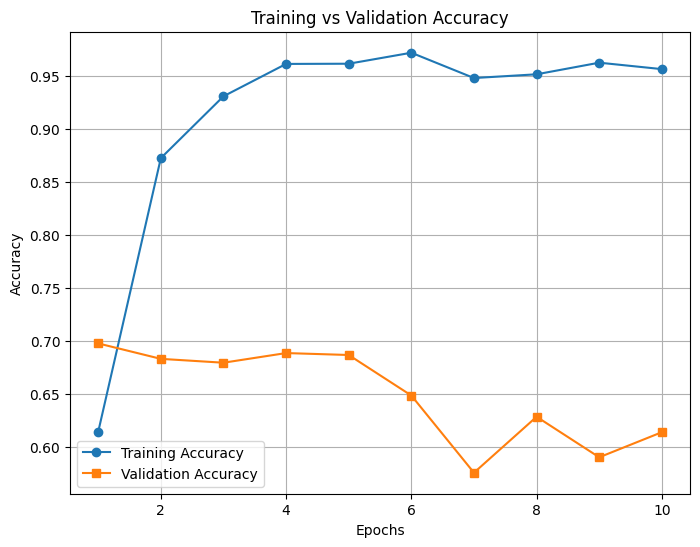

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_acc_history) +1), train_acc_history, label='Training Accuracy', marker='o')
plt.plot(range(1, len(val_acc_history) +1), val_acc_history, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/ViT_ImageNet/vit_imagenet160classes.pth")
print("Model saved successfully")

Model saved successfully


In [ ]:
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=160)

model.load_state_dict(torch.load("/content/drive/MyDrive/ViT_ImageNet/vit_imagenet160classes.pth"))

model.to(device)

model.eval()

print("Model loading successful")

<ipython-input-14-fb3afca49fab>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/ViT_ImageNet/vit_imagenet160classes

Model loading successful


In [ ]:
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
image_path = "/content/drive/MyDrive/ViT_ImageNet/Test Image/ILSVRC2012_val_00027831.JPEG"

image = Image.open(image_path)

input_tensor = transform(image).unsqueeze(0).to(device)

In [ ]:
with torch.no_grad():
  output = model(input_tensor)
  predicted_class = torch.argmax(output, dim=1).item()


class_labels = train_dataset.classes
predicted_label = class_labels[predicted_class]


print(f"Predicted Class: {predicted_class} - {predicted_label}")

Predicted Class: 13 - n01534433


Text(0.5, 1.0, 'Class n01534433 was predicted for the given Image')

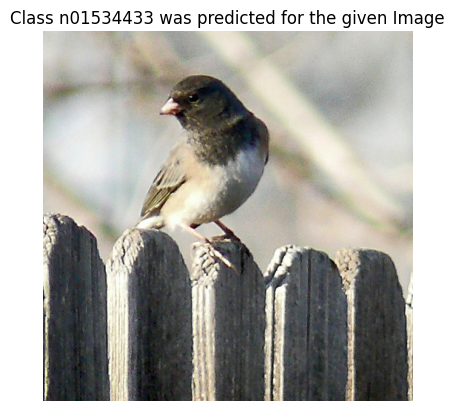

In [ ]:
plt.imshow(image)